### **Importing Libraries**

In [1]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time
import matplotlib.pyplot as plt

# Function to download and load dataset
def load_data():
    page_url = 'https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones'
    page_response = requests.get(page_url)
    if page_response.status_code == 200:
        soup = BeautifulSoup(page_response.content, 'html.parser')
        download_link = soup.select_one('a[href$=".zip"]')['href']
        full_download_url = 'https://archive.ics.uci.edu' + download_link
        response = requests.get(full_download_url)
        if response.status_code == 200:
            with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
                inner_zip_name = 'UCI HAR Dataset.zip'
                with outer_zip.open(inner_zip_name) as inner_zip_file:
                    with zipfile.ZipFile(io.BytesIO(inner_zip_file.read())) as inner_zip:
                        with inner_zip.open('UCI HAR Dataset/train/X_train.txt') as myfile:
                            df = pd.read_csv(myfile, delim_whitespace=True, header=None)
                        with inner_zip.open('UCI HAR Dataset/train/y_train.txt') as myfile_y:
                            y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)
    else:
        raise Exception("Failed to download or parse the dataset.")
    return df, y

###**Load Dataset**

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import numpy as np
import time

# Load dataset
df, y = load_data()

<ipython-input-1-3aa7f2d70fe2>:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(myfile, delim_whitespace=True, header=None)
<ipython-input-1-3aa7f2d70fe2>:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)


###**Exploratory Data Analysis**

In [20]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [21]:
y.head()

,0
0,5
1,5
2,5
3,5
4,5


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB


In [23]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [24]:
print(df.isnull().sum())

0      0
1      0
2      0
3      0
4      0
      ..
556    0
557    0
558    0
559    0
560    0
Length: 561, dtype: int64


In [25]:
y.nunique()

,0
0,6


(array([1226.,    0., 1073.,    0.,  986.,    0., 1286.,    0., 1374.,
        1407.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

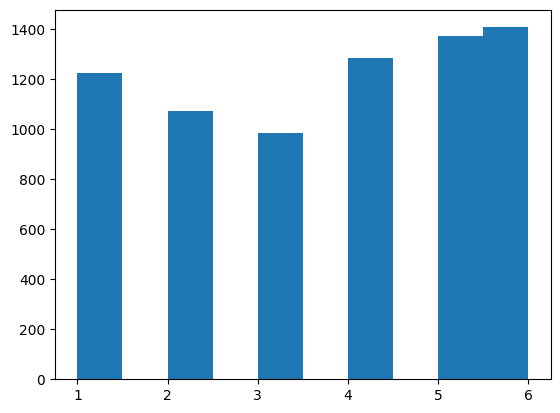

In [26]:
plt.hist(y)

###**Encoding the Class Labels**

In [27]:
label_encoder = LabelEncoder()
encoded_y  = label_encoder.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###**Scale the Features**

In [28]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

###**Split the Data**

In [29]:
X_train_full, X_test_full, y_train, y_test =train_test_split(df_scaled, encoded_y, test_size=0.2, random_state=42)

###**Model Building**

In [30]:
start_time = time.time()
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
model = GaussianNB()
model.fit(X_train_full, y_train)
end_time = time.time()

###**Prediction & Accuracy**

In [31]:
y_pred = model.predict(X_test_full)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7314751869476547


###**Time Taken**

In [32]:
print("Time taken:", end_time - start_time, "seconds")

Time taken: 0.03533577919006348 seconds


###**Dimensionality Reduction**

In [33]:
# TASK 7 - K-Means for dimensionality reduction
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(df_scaled.T)  # Transpose to treat features as data points
selected_features_indices = [np.random.choice(np.where(kmeans.labels_ == i)[0]) for i in range(n_clusters)]
selected_features = df_scaled[:, selected_features_indices]

###**Training Data After Dimensionality Reduction**

In [34]:
#TASK 8 - Train another model (GaussianNB) on the new dataset, and report time taken and accuracy
X_train_reduced, X_test_reduced, y_train, y_test =train_test_split(selected_features, encoded_y, test_size=0.2, random_state=42)

###**Model Building After Dimensionality Reduction**

In [35]:
start_time = time.time()
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
model = GaussianNB()
model.fit(X_train_reduced, y_train)
end_time = time.time()

###**Prediction & Accuracy After Dimensionality Reduction**

In [37]:
y_pred = model.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8076138681169273


###**Time Taken After Dimensionality Reduction**

In [38]:
print("Time taken:", end_time - start_time, "seconds")

Time taken: 0.01502084732055664 seconds
